
# 本筆記的目的：了解如何Deep Convolutional GAN (DCGAN)

* install require package ：tf,keras,matplotlib, ...

---

# 索引

1. [準備載入相關資料](#1.-準備載入相關資料)
2. [設定照片尺寸](#2.-設定照片尺寸)
3. [生成—判別器定義](#3.-Generator-Discrimination-Formula-Function-Paper-Define)
4. [設定Generator](#4.-Generator)
5. [設定Discriminator](#5.-Discriminator)
6. [模型的定義](#6.-Define-how-to-build-the-Model)
7. [創建模型](#7.-Build-Model-Display-Model-infomation)
8. [顯示讀入圖片](#8.-Show-Image)
9. [讀取NPM檔](#9.-Read-Data-and-Saving-to-npm-file)
10. [載入NPM檔](#10.-Load-npz-file-to-Training-Testing-Dataset)
11. [訓練](#11.-Training)
12. [判別器損失](#12.-Discriminator-Loss)
13. [生成器損失](#13.-Generator-Loss)
14. [模型參數設定](#14.-Train-the-Model-Setting-Parameter-and-Inspect-Output)
15. [*結果:全部損失](#15.-Total-Loss)
16. [儲存訓練模型](#16.-Save-Model-checkpoints)
17. [顯示輸出圖片](#17.-Show-OUT-Image)
18. [後記](#18.-後記)

---


Generative Adversarial Network 簡稱 GAN 中文是對抗式生成網路，是一個這幾年很紅的一個網路模型．是在 2014 年的這篇 [論文 by Ian Goodfellow](https://arxiv.org/abs/1406.2661) 被提出來的．

它理論的出發點很有趣，很普遍來解釋這個模型的例子是，可以先想像現在有一個製造偽鈔的罪犯，還有一個很會辨識偽鈔的鑑識人員．一個很厲害的偽鈔製作員的定義就是，它做出的偽鈔讓人無法分出和真的鈔票有什麼不一樣；而一個很會辨識的鑑識人員，則是可以分辨出每一張偽鈔．這一種競爭關係在 Game Theory 中被稱作 min max game．

而對抗式生成網路 (GAN) 就是這種關係在神經網中的實現．其中它包括了兩個神經網路，一個代表罪犯的生成式網路 (Generator)；另一個代表鑑識人員的鑑別式網路 (Discriminator)．生成式網路負責產生資料，而鑑別式網路負責判斷資料和真實資料的差異．它的輸出會是一個從 0 到 1 的數字，代表著輸入資料是真實資料的機率．例如輸出是 1 代表著它判斷 100% 這是真實資料，輸出是 0 代表這 100% 是假的資料．

理論上訓練到最後，當輸入生成式網路產出的資料給鑑別式網路，它的輸出會是 0.5，代表著它沒有辦法區分這是真實還是假的．

以下會利用 MNIST[不再這次之內]/PET 資料集來嘗試訓練一個 GAN[不再這次之內]/DCGAN．

## 1. 準備載入相關資料

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.
/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtype

[[返回索引]](#索引)

## 2. 設定照片尺寸

In [3]:
img_rows =  320
img_cols =  180
channels =  1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

[[返回索引]](#索引)

## 3. Generator-Discrimination-Formula-Function-Paper-Define

在定義訓練 cost 函數的時候，和之前的神經網路比較不一樣的地方是它沒有一個標準的 loss 計算．畢竟這個模型要判斷的問題是真或假的問題．可以參考以下從[論文](https://arxiv.org/abs/1406.2661)摘錄出來的演算法片段，我們可以從以下步驟一一來看．


![](https://github.com/c1mone/Tensorflow-101/blob/master/notebooks/images/13_Generative_Adversarial_Network/GAN_algorithm.jpg?raw=true)



[[返回索引]](#索引)

## 4. Generator

In [4]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 80 * 45, input_dim=z_dim))
    model.add(Reshape((80, 45, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation 28* 28
    model.add(Activation('tanh'))
    model.summary()
    
#     model.add(Dense(1920*1080*1,activation='tanh'))

    return model

[[返回索引]](#索引)

## 5. Discriminator

In [5]:
def build_discriminator(img_shape):
    print("D: --{}--\n", img_shape)

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    #1920-> 960, 1080->540
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    #960-> 480, 540->270
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    #480-> 240, 270->135
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    #240-> 1, 135->1
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

[[返回索引]](#索引)

## 6. Define-how-to-build-the-Model

In [6]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

[[返回索引]](#索引)

## 7. Build-Model-Display-Model-infomation

In [7]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)
z = np.random.normal(0, 1, (4, 100))
print (generator.predict(z).shape)
# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

D: --{}--
 (320, 180, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 160, 90, 32)       320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 160, 90, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 45, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 45, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 80, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 23, 128)   

[[返回索引]](#索引)

## 8. Show-Image

(3000, 4000, 3)


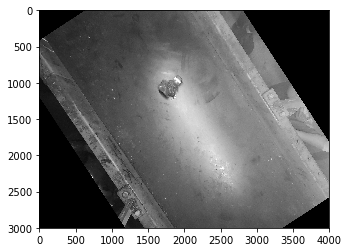

In [8]:
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
from matplotlib.colors import NoNorm
import numpy as np
lena = plt.imread("/home/e200/UNIT/datasets/soy2Vcrash/trainB/GOPR1294_23.jpg")
# 读取和代码处于同一目录下的 lena.png
# 此时 lena 就已经是一个 np.array 了，可以对它进行任意处理
print(lena.shape) #(512, 512, 3)

plt.imshow(lena[:,:,2], cmap='gray')#,interpolation='none')
# plt.imshow(lena,cmap=plt.get_cmap('gray') )# 显示图片
# plt.axis('off') # 不显示坐标轴
# plt.show()

[[返回索引]](#索引)

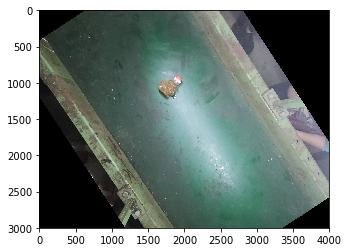

In [9]:
plt.imshow(lena)#,interpolation='none')

## 9. Read-Data-and-Saving-to-npm-file

*.z的label都是先改成是0,都是假資料：正常醬油瓶[label:0],L形醬油瓶[label:1],垂直壓扁醬油瓶[label:2], ...

*.X的label都是先改成是1,都是真資料：先全部都是L形醬油瓶[label:1]

In [10]:

from glob import glob
import matplotlib.pyplot as plt #用于显示图片
from skimage.transform import resize
''' 生成sklearn training PET soy dataSet''' 
def load_imgesets(flist, out_npz,h, w):     
#def load_imgesets(flist, fList1,out_npz,h, w):  
    data = []
    # X_train = data
    data = np.array(data,dtype=float)
    flag = 1
    for fs in glob(flist):
        if flag == 1:
            flag = 0            
            # print (misc.imresize( Image.open(str[0]).convert('L'),(h,w) ).shape,"\n")
#              data = np.asarray(resize( plt.imread(fs)[:,:,1],(h,w) )).reshape(1,-1)
            data = np.asarray(resize( plt.imread(fs)[:,:,1],(h,w) )).reshape(1,w,h)
        else:
            row = np.asarray(resize( plt.imread(fs)[:,:,1],(h,w) )).reshape(1,w,h)
            #np.array(Image.open(str[0]).convert('L')).reshape(1, -1)
            data = np.row_stack((data, row))
    # x_test = data1 
    data1= np.zeros(len(glob(flist)))
    #=========================================== fList1 ==> y_train , y_test 
#     for fs in glob(flist1):
#         if flag == 1:
#             flag = 0            
#             # print (misc.imresize( Image.open(str[0]).convert('L'),(h,w) ).shape,"\n")
#             data2 = np.asarray(resize( plt.imread(fs)[:,:,1],(h,w) )).reshape(1,w,h)
#         else:
#             row = np.asarray(resize( plt.imread(fs)[:,:,1],(h,w) )).reshape(1,w,h)
#             #np.array(Image.open(str[0]).convert('L')).reshape(1, -1)
#             data = np.row_stack((data, row))
#     # y_test = data3 
#     data3= np.ones(len(glob(flist1)))
    #=========================================== fList1 ==> y_train , y_test 
    
#     np.savez('my_array3',*data,*data1)
    np.savez(out_npz,x_train=data,x_test=data1) 
#     np.savez(out_npz,x_train=data,x_test=data1,y_train= data2, y_test=data3) 
    return data ,data1

[[返回索引]](#索引)

In [11]:
# (X_train, X_test) =load_imgesets("/home/gilbert3/Documents/mnt/images/*.jpg","my_array3",28,28)
(X_train, X_test) =load_imgesets("/media/e200/新增磁碟區/iaa_dataaugment/dataset/images/*.jpg","my_array3",1080,1920)
#, (Y_train,Y_test)
# (Y_train, Y_test) =load_imgesets("/home/gilbert3/Documents/mnt/images/*.jpg","my_array3",1080,1920)
Y_test = X_test
Y_train = X_train

In [12]:
print(Y_train.shape,Y_test.shape)

(2, 1920, 1080) (2,)


## 10. Load-npz-file-to-Training-Testing-Dataset

In [13]:

container =  np.load('my_array3.npz')
data3 = [container[key] for key in container]
# for key in container:
#     print(key)
# print(container['x_train'])
print (type(data3))
print(len(data3))
print(type(data3[0]))
print((data3[0].shape),data3[1].shape)
# print( data3[0][0] )

<class 'list'>
2
<class 'numpy.ndarray'>
(2, 1920, 1080) (2,)


[[返回索引]](#索引)

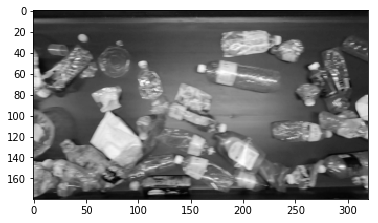

In [14]:
h = 1080
w = 1920
plt.imshow(np.array(data3[0][0]).reshape(h,w))
plt.imshow( np.array(data3[0][0]).reshape(h,w),cmap='gray')
plt.imshow( resize(np.array(data3[0][0]).reshape(h,w),(180,320)),cmap='gray')

## 11. Training

In [40]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    # (X_train, _), (_, _) = mnist.load_data()
    (X_train, X_test) =load_imgesets("/media/e200/新增磁碟區/iaa_dataaugment/dataset/images/*.jpg","my_array3",img_cols,img_rows)
    Y_test = X_test
    Y_train = X_train
    
#     X_train = np.asarray(X_train.reshape(-1,w,h))
    
    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    print ("=====train [X_train.shape]:{}  = (X_train.shape[0]):{} -----\n ".format(X_train.shape,X_train.shape[0]))
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))
    ii = 1
    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        print ("z.shape",z.shape)
        gen_imgs = generator.predict(z)
        if ii % 100 == 0:
            print("{}:----[imgs.shape]:{} = [real.shape]:{} = [gen_imgs.shape]:{} = [fake.shape]:{}---\n ".format(ii, imgs.shape,real.shape, gen_imgs.shape,fake.shape))
        else:
            print("{}:\n".format(ii))
        ii = ii+1
        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

[[返回索引]](#索引)

## 12. Discriminator-Loss

        *. d_loss_real = discriminator.train_on_batch(imgs, real)
        *. d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        *. d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

#### 計算 discriminator cost

- 一開始先要從一個 noise prior 取樣出資料給 generator 產生 MNIST 假資料，然後再把假資料丟給 discriminator 產生輸出稱作 `d_fake`．這裡使用 `uniform 分佈`當作 prior．
- 把真正的訓練資料丟給 discriminator 產生輸出稱作 `d_real`．
- 定義 discriminator 的 loss 為 `-tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))`，其意義為要讓 `d_real` 和 `1 - d_fake` 越大越好，而加上負號讓 tensorflow 去做最小化．


## 13. Generator-Loss
        *. z = np.random.normal(0, 1, (batch_size, 100))
        *. gen_imgs = generator.predict(z)
        *. g_loss = gan.train_on_batch(z, real)


#### 計算 generator cost

- 最小化 `1 - d_fake` 也就是讓 geneartor 產生的輸出越不被判斷成假的越好．
- 論文中後來有一段說明最小化 `-d_fake` 會比直接最小化 `1 - d_fake` 來得好，因此這裡使用前者．

In [41]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    h = 36
    w = 64
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(resize(gen_imgs[cnt, :, :, 0],(h,w)), cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

[[返回索引]](#索引)

## 14. Train-the-Model-Setting-Parameter-and-Inspect-Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

=====train [X_train.shape]:(2, 320, 180)  = (X_train.shape[0]):2 -----
 
z.shape (32, 100)
1:

z.shape (32, 100)
2:

z.shape (32, 100)
3:

z.shape (32, 100)
4:

z.shape (32, 100)
5:

z.shape (32, 100)
6:

z.shape (32, 100)
7:

z.shape (32, 100)
8:

z.shape (32, 100)
9:

z.shape (32, 100)
10:

z.shape (32, 100)
11:

z.shape (32, 100)
12:

z.shape (32, 100)
13:

z.shape (32, 100)
14:

z.shape (32, 100)
15:

z.shape (32, 100)
16:

z.shape (32, 100)
17:

z.shape (32, 100)
18:

z.shape (32, 100)
19:

z.shape (32, 100)
20:

z.shape (32, 100)
21:

z.shape (32, 100)
22:

z.shape (32, 100)
23:

z.shape (32, 100)
24:

z.shape (32, 100)
25:

z.shape (32, 100)
26:

z.shape (32, 100)
27:

z.shape (32, 100)
28:

z.shape (32, 100)
29:

z.shape (32, 100)
30:

z.shape (32, 100)
31:

z.shape (32, 100)
32:

z.shape (32, 100)
33:

z.shape (32, 100)
34:

z.shape (32, 100)
35:

z.shape (32, 100)
36:

z.shape (32, 100)
37:

z.shape (32, 100)
38:

z.shape (32, 100)
39:

z.shape (32, 100)
40:

z.shape (32, 100

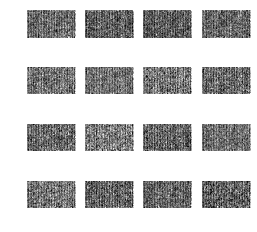

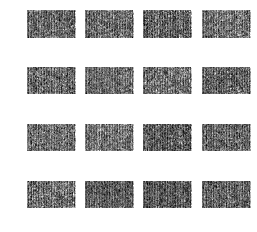

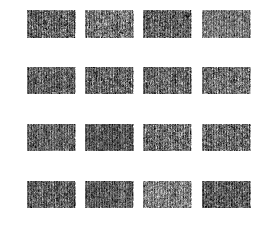

In [42]:
# Set hyperparameters
iterations = 201
batch_size = 32 # ==> (purny) 
sample_interval = 64

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

[[返回索引]](#索引)

## 15. Total-Loss
        *.losses = d_loss + g_loss

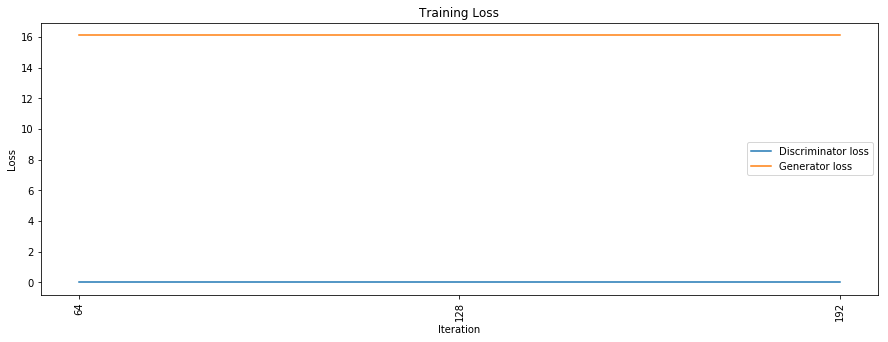

In [43]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

[[返回索引]](#索引)

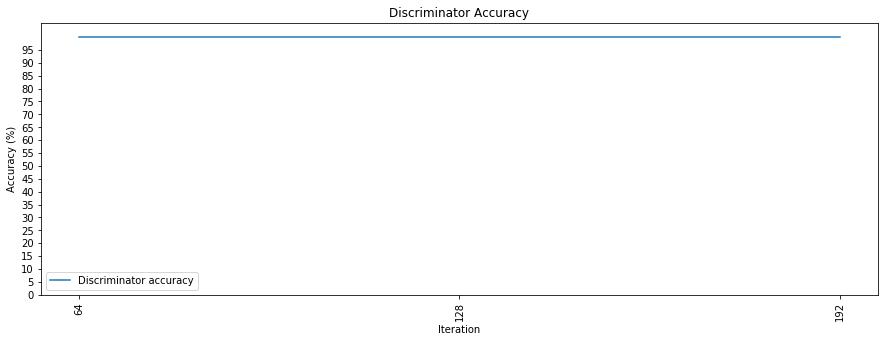

In [44]:
accuracies = np.array(accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

[[返回索引]](#索引)

## 16. Save-Model-checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [46]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./training', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
# Fit the model
# model.fit(X, Y, validation_split=0.33, nb_epoch=150, batch_size=10,callbacks=callbacks_list, verbose=0)

[[返回索引]](#索引)

## 17. Show-OUT-Image

[[返回索引]](#索引)

---

## 18. 後記

1.z的label都是先改成是0,都是假資料：正常醬油瓶[label:0],L形醬油瓶[label:1],垂直壓扁醬油瓶[label:2], ...

2.X的label都是先改成是1,都是真資料：先全部都是L形醬油瓶[label:1]

[[返回索引]](#索引)